# Síťová analýza PID

## Data
Jako dataset nám poslouží [otevřená data Pražské integrované dopravy](https://pid.cz/o-systemu/opendata/). Konkrétně budeme pracovat s daty [cestovních řádů](https://pid.cz/o-systemu/opendata/#h-gtfs), která jsou původně ve formátu GTFS (General Transit Feed Specification). To je formát, který využívá široká škála softwarových aplikací a kvůli tomu jej při publikaci dat využívají také veřejné dopravní agentury včetně PID.

# Zpracování
K vykreslování grafů jsem si vybral balíček `networkx`. Zároveň budou veškeré vizualizce anglicky z důvodu formátu dat, který je taktéž v angličtině.

In [95]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

## Načtení a čištění hlavního datasetu
Načtu a prozkoumám formát datasetu a nahradím případné prázdné hodnoty pomocí `np.nan`

In [96]:
# load data and replace null values with np.nan
data = pd.read_csv('data.csv').fillna(np.nan)

In [97]:
# show info and null values count 
display(data.head())
display(data.info())

# count empty values
print('Empty values:', data.isna().sum().sum())

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,U2991Z301,Hněvice,T58005,Hněvice seř.n.,4:53:00,4:54:30,2,0,1,1,1,1,1,0,0
1,T58005,Hněvice seř.n.,U4610Z301,Záluží,4:54:30,4:56:00,2,0,1,1,1,1,1,0,0
2,U4610Z301,Záluží,U4609Z301,Dobříň,4:56:00,4:59:00,2,0,1,1,1,1,1,0,0
3,U4609Z301,Dobříň,U4608Z301,Roudnice nad Labem,4:59:00,5:03:00,2,0,1,1,1,1,1,0,0
4,U4608Z301,Roudnice nad Labem,U4609Z301,Dobříň,4:36:00,4:38:00,2,0,1,1,1,1,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642433 entries, 0 to 1642432
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   stop_from       1642433 non-null  object
 1   stop_from_name  1642433 non-null  object
 2   stop_to         1642433 non-null  object
 3   stop_to_name    1642433 non-null  object
 4   depart_from     1642433 non-null  object
 5   arrive_to       1642433 non-null  object
 6   route_type      1642433 non-null  int64 
 7   is_night        1642433 non-null  int64 
 8   monday          1642433 non-null  int64 
 9   tuesday         1642433 non-null  int64 
 10  wednesday       1642433 non-null  int64 
 11  thursday        1642433 non-null  int64 
 12  friday          1642433 non-null  int64 
 13  saturday        1642433 non-null  int64 
 14  sunday          1642433 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 188.0+ MB


None

Empty values: 0


Můžeme pozorovat, že v datesetu je `1642433` záznamů a `15` příznaků. Z toho je většina příznaků numerických. Nenumerické příznaky přetypuji na *string*.

Zároveň dataset neobsahuje žádné prázdné hodnoty.

In [98]:
# change object type to string
objects = ['stop_from', 'stop_from_name', 'stop_to', 'stop_to_name']
data[objects] = data[objects].astype('string')

Ještě prozkoumám počet unikátních názvů zastávek v datasetu.

In [99]:
print('Unique count:', pd.Series(list(data['stop_from_name']) + list(data['stop_to_name'])).nunique())

Unique count: 7396


### Počet unikátních zastávek pro typy dopravy
Není uplne možné přehledně vizualizovat `7396` unikátních vrcholů grafu. Proto si pro vizualizaci vyberu nějakou podmožinu poskytnutých dat.

Budu tedy vybírat mezi jednotlivými dopravními prostředky na základě počtu unikátních jmen zastávek.

Zde se nabízí vhodná vizualizace pomocí **sloupcového grafu** se sloupcem pro každý z dopravních prostředků.

/tmp/ipykernel_14347/1982035829.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


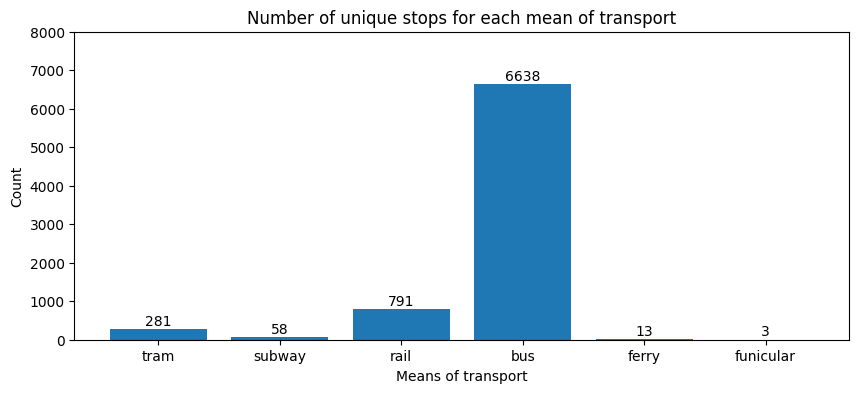

In [100]:
# filter data using names and route type, then remove duplicates
x = data[['stop_from_name', 'stop_to_name', 'route_type']].drop_duplicates()

# get dataframe of unique stop names with its corresponding route type
unique_route_stops = pd.DataFrame(
    np.concatenate([
        x[['stop_from_name', 'route_type']], 
        x[['stop_to_name', 'route_type']]], axis=0

    )).rename({
        0 : 'name',
        1 : 'route_type'

    }, axis=1).drop_duplicates()

# transport means coding dict
means = {
    0 : 'tram',
    1 : 'subway',
    2 : 'rail',
    3 : 'bus',
    4 : 'ferry',
    7 : 'funicular'
}

modes_df = unique_route_stops.copy()

# groupby route type so we get sum of stops for each transport type
modes_df['name'] = 1
modes_df = modes_df.groupby('route_type').sum().reset_index().rename({ 'name' : 'count' }, axis=1)

# code route_type to readable text
modes_df['route_type'] = modes_df['route_type'].apply(lambda x: means[x])

x, y = modes_df['route_type'], modes_df['count']

# plot graph
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x, y)
ax.set_ylim(0, 8000)

# add count for each bar
y_offset = 100
for i in range(len(x)):
    plt.text(i, y[i] + y_offset, y[i], ha = 'center')

ax.set_title('Number of unique stops for each mean of transport')
ax.set_ylabel('Count')
ax.set_xlabel('Means of transport')
fig.show()

Z grafu jasně vidíme počet unikátních zastávek pro každý dopravní prostředek.

Na základě této vizualizace jsem se rozhodl pracovat primárně s daty **tramajových linek**.

## Načtení a čištění datasetu s lokací zastávek
Zde opět načtu dataset a provedu základní analýzu dat.

In [101]:
# load stops from csv and replace empy values with np.nan
stops = pd.read_csv('stops.txt').fillna(np.nan)

In [102]:
display(stops.head())
display(stops.info())

display(stops.isna().sum())

,stop_id,stop_name,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,wheelchair_boarding,level_id,platform_code,asw_node_id,asw_stop_id
0,U50S1,Budějovická,50.044411,14.448787,P,NaN,1,NaN,1,NaN,NaN,50.0,NaN
1,U52S1,Chodov,50.031672,14.490961,P,NaN,1,NaN,1,NaN,NaN,52.0,NaN
2,U75S1,Kolbenova,50.110395,14.516398,P,NaN,1,NaN,1,NaN,NaN,75.0,NaN
3,U78S1,Ládví,50.126591,14.469451,P,NaN,1,NaN,1,NaN,NaN,78.0,NaN
4,U100S1,Vltavská,50.100298,14.438492,P,NaN,1,NaN,1,NaN,NaN,100.0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16435 entries, 0 to 16434
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   stop_id              16435 non-null  object 
 1   stop_name            15936 non-null  object 
 2   stop_lat             16435 non-null  float64
 3   stop_lon             16435 non-null  float64
 4   zone_id              15408 non-null  object 
 5   stop_url             0 non-null      float64
 6   location_type        16435 non-null  int64  
 7   parent_station       954 non-null    object 
 8   wheelchair_boarding  16435 non-null  int64  
 9   level_id             954 non-null    object 
 10  platform_code        14750 non-null  object 
 11  asw_node_id          15748 non-null  float64
 12  asw_stop_id          15354 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 1.6+ MB


None

stop_id                    0
stop_name                499
stop_lat                   0
stop_lon                   0
zone_id                 1027
stop_url               16435
location_type              0
parent_station         15481
wheelchair_boarding        0
level_id               15481
platform_code           1685
asw_node_id              687
asw_stop_id             1081
dtype: int64

Můžeme vidět, že tento dataset obsahuje informace o jednotlivých zastávkách.

Z těchto dat mě budou primárně zajímat **GPS souřadnice**.

Obsahuje pouze `16435` záznamů a `13` příznaků. Taktéž obsahuje velké množství chybějících hodnot. Z toho ale žádné nejsou `stop_lat` a `stop_lon`.

Dále jsou zde opět příznaky bez typu, které přetypuji na *string*.

In [103]:
# change object types onto string
objects = ['stop_id', 'stop_name', 'zone_id', 'parent_station', 'level_id', 'platform_code']
stops[objects] = stops[objects].astype('string')

## Předzpracování hlavního datasetu

Jelikož se u příznaků `depart_from` a `arrive_to` nacházejí hodnoty větší než 24 hodin, tak nemůžeme provést konverzi na datový typ *date*.

Zde tedy aplikuji funkci *mod24*. Tím se zbavím hodnot větších než 24:00.

Dále můžeme na základě této skutečnosti vypočítat čas jízdy dopravního prostředku ze zastávky A do zastávky B a to pro každou dvojici v datasetu.

### Mod24 a konverze časových příznaků

Funkce ořezání času většího než 24 hodin.

In [104]:
def mod_time_24(series):
    """ Apply mod24 on all items in series """

    def mod_hours(time):
        """ Apply mod24 on hours """

        h, m, s = time.split(':')
        return str(int(h) % 24) + ':' + m + ':' + s

    return pd.Series([mod_hours(x) for x in series])

Nzní aplikuji funkci mod24 a přetypuji další časové příznaky na *datetime*.

In [105]:
# apply mod24 on time
data['depart_from'] = mod_time_24(data['depart_from'])
data['arrive_to'] = mod_time_24(data['arrive_to'])

# convert onto timedelta type
data['depart_from'] = pd.to_timedelta(data['depart_from'])
data['arrive_to'] = pd.to_timedelta(data['arrive_to'])

### Přidání času mezi zastávkami
Na základě času odjezdu a příjezdu mohu pro každý spoj vypočítat dobu jízdy.

In [106]:
def time_delta_diff(df):
    """ Return difference series between department and arrival """
    return pd.Series([abs(a - d) for a, d in zip(df['arrive_to'], df['depart_from'])])

In [107]:
# add difference between depart and arrive time
data['delta_time'] = time_delta_diff(data)

### Přidání příznaku weekly
Dále by se mohl hodit příznak součtu dnů ve které daný spoj jezdí.

In [108]:
# sum monday to sunday and join with data
df = pd.DataFrame()
df['weekly'] = data.loc[:,'monday':'sunday'].sum(axis=1)

data = data.join(df)

## Síťová analýza

Jak jsem již zmiňoval, tak budu primárně vizualizovat tramvajové spoje.

Zároveň budu vykreslovat graf geograficky přesně s ohledem na **GPS souřadnice** dané zastávky.

Vytořím tedy funkci, která mi pro **ID zastávky** vrátí jeho souřadnice.

In [109]:
def find_coords(ID: str) -> tuple:
    """ Return tuple of lat and lon by given stop ID """

    try:
        row = stops.loc[stops['stop_id'] == ID]
        idx = row.index

        return (float(row.loc[idx]['stop_lat']), float(row.loc[idx]['stop_lon']))
    except:
        return None

Dále vytvořím funkci pro samotnou tvorbu **orientovaného** grafu.

Ta bude obsahovat filtraci dvojic zastávek, agregaci unikátních hodnot do příznaku `weight` a tvorbu samotneho grafu.

Příznak `weight` bude atribut hrany, který údává počet průjezdů mezi dvěmi zastávkami za jeden týden.

In [110]:
def create_stops_graph(df):
    """ Create graph from filtered stops dataframe """

    # drop unnecessary features
    df_dropped = df.drop(['depart_from', 'arrive_to', 'route_type'], axis=1).drop_duplicates()

    # get weighted edges by weekly load
    weighted_edges = pd.DataFrame({'weight' : df[['stop_from_name', 'stop_to_name']].groupby(['stop_from_name', 'stop_to_name']).size()}).reset_index()

    # cycle trough unique pairs of stops and create directed graph
    G = nx.DiGraph()
    for i, row in weighted_edges.iterrows():

        from_name, to_name = row['stop_from_name'], row['stop_to_name']

        # get stop from attrib by name
        from_row = dict(df_dropped[df_dropped['stop_from_name'] == from_name].iloc[0])
        del from_row['stop_to'], from_row['stop_to_name']

        # get stop to attrib by name
        to_row = dict(df_dropped[df_dropped['stop_to_name'] == to_name].iloc[0])
        del to_row['stop_from'], to_row['stop_from_name']

        # separate from and to IDs
        from_ID, to_ID = from_row['stop_from'], to_row['stop_to']
        del from_row['stop_from'], to_row['stop_to']

        # get route time delta on edge
        edge_delta_time = df_dropped[(df_dropped['stop_from_name'] == from_name) & (df_dropped['stop_to_name'] == to_name)].iloc[0]['delta_time']

        # nodes
        G.add_node(from_name, ID=from_ID, **from_row)
        G.add_node(to_name, ID=to_ID, **to_row)

        # add edge between those nodes
        G.add_edge(from_name, to_name, weight=int(row['weight']), delta_time=edge_delta_time)

    return G

Teď už jen vytvořím graf z tramvajových dat a získám pro každý vrchol GPS souřadnice.

In [ ]:
# create graph from tram data
G = create_stops_graph(data[(data['route_type'] == 0)])

# get ID for each node
IDs = nx.get_node_attributes(G, 'ID')
GPS = {}

# fill GPS dict with node name as key and GPS as value
for node in nx.get_node_attributes(G, 'ID'):
    GPS[node] = np.array(find_coords(IDs[node]))[::-1]

### Základní vizualizace tramvajové sítě

Nejdříve se podívám na prvních 10 zastávek grafu, abych ověřil, že se opravdu jedná o tramvajové zastávky Prahy.

Zároveň tím zjistíme, jestli náš vytovřený graf není prázdný.

In [112]:
print('Nodes count:', len(G.nodes), end='\n\n')
print(*list(G.nodes)[:10], sep='\n')

Nodes count: 281

Albertov
Botanická zahrada
Ostrčilovo náměstí
Výtoň
Anděl
Arbesovo náměstí
Bertramka
Křížová
Na Knížecí
Zborovská


Dle zastávek se pravděpodobně bude jednat o tramvajovou sit **Prahy**. Proto si ještě uložím veškeré vrcholy, které mají stupeň 1.

Takto získám všechny konečné zastávky.

In [113]:
# get nodes with degree equal to 1
terminal_stops = [stop for stop, deg in dict(G.to_undirected().degree).items() if deg == 1]
print(*terminal_stops, sep='\n')

Sídliště Řepy
Zvonařka
Bílá Hora
Divoká Šárka
Holyně
Nádraží Hostivař
Spojovací
Lehovec
Levského
Vozovna Kobylisy
Ústřední dílny DP
Vozovna Pankrác
Nádraží Podbaba
Sídliště Petřiny
Radlická
Spořilov


Konečné zastávky taktéž naznačují, že se jedná o Prahu. Konečně tedy vykreslím geograficky správný graf tramvajových spojů s názvy konečných zastávek.

Pro zobrazení názvů zastávek v grafu si ještě vytvořím funkci na jejich posunutí.

In [114]:
def offset_labels_pos(label_pos, x_off, y_off):
    """ Return offsetted label positions """

    new_pos = {}
    for key, value in label_pos.items():
        new_pos[key] = (value[0] + x_off, value[1] + y_off)

    return new_pos

/tmp/ipykernel_14347/907444622.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


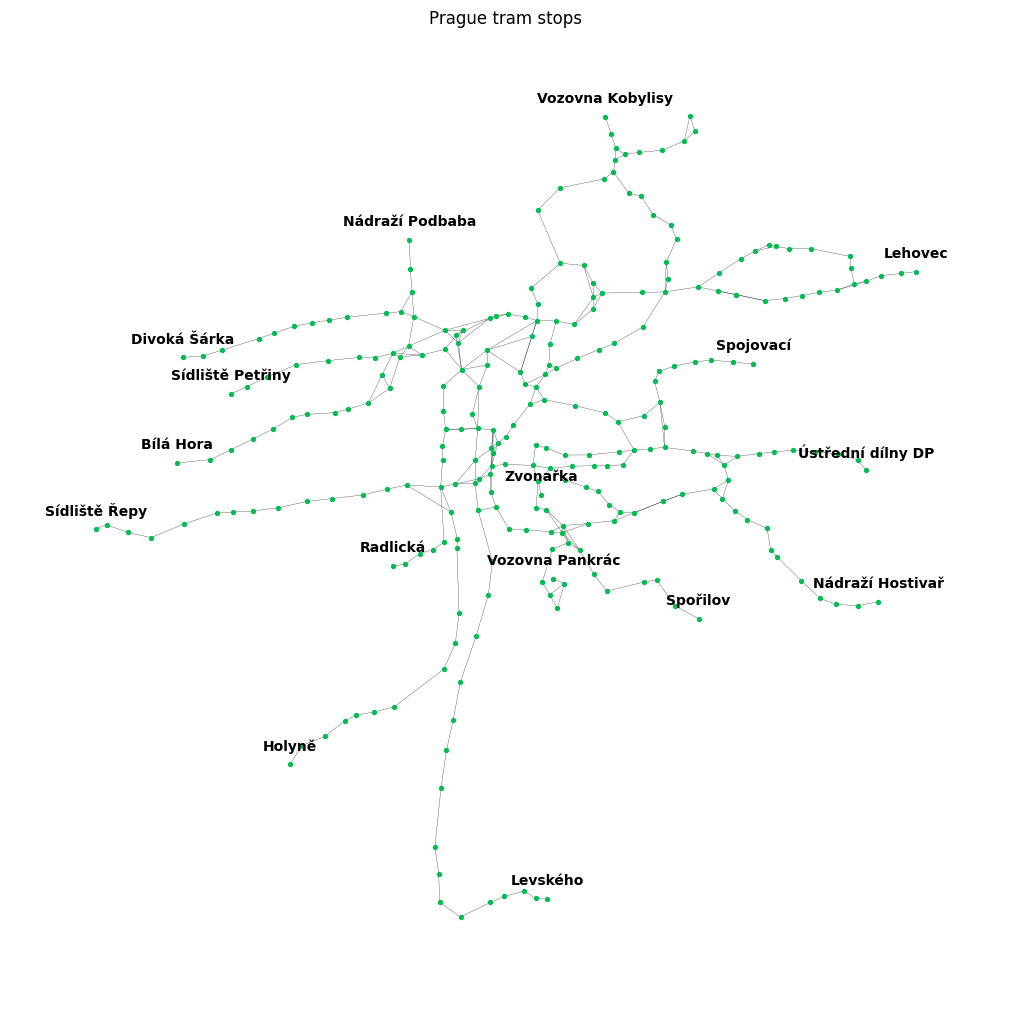

In [115]:
fig, ax = plt.subplots(figsize=(10, 10), layout='constrained')
ax.set_title('Prague tram stops')

# draw undirected graph with params
nx.draw(G.to_undirected(), **{
    'pos' : GPS,
    'node_size' : 8,
    'node_color' : '#02BE50',
    'width': 0.2,
})

# draw terminal station labels
nx.draw_networkx_labels(G, **{
    'pos' : offset_labels_pos(GPS, 0, 0.003),
    'labels' : {label:label for label in terminal_stops},
    'font_size' : 10,
    'font_weight' : 'bold'
})

fig.show()

Z vizualizace můžeme opravdu vidět, že se jedná o graf Pražských tramvajových zastávek.

## Týdenní zatížení tramvajových tras
Tato vizualizace by se mohla řadit do vlastních otázek. Ovšem mi dává smysl graf zatížení tras zobrazit v rámci základní analýzy dat.

V předzpracování jsem si pro každou dvojici tramvajových zastávek vypočítal jak často se zde za týden objeví. Tuto informaci zobrazím pomocí obarvení hran předchozího grafu.

Min: 1, Max: 2491


/tmp/ipykernel_14347/1297046912.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


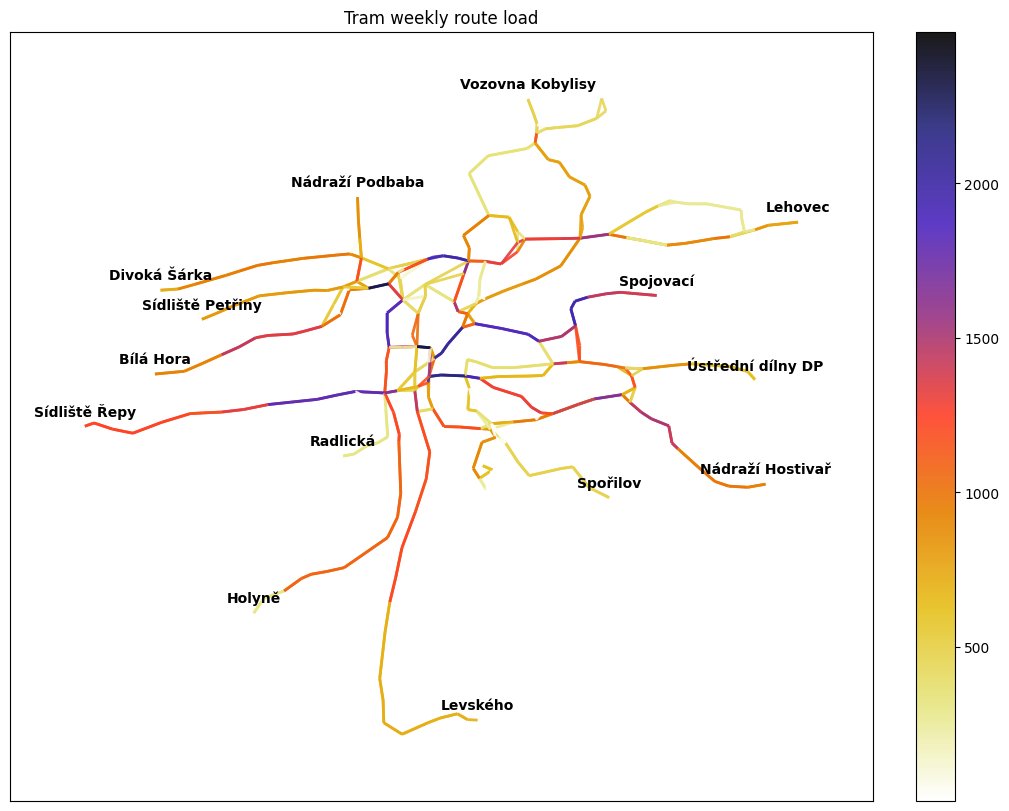

In [116]:
# get edges with weight attributes
w = nx.get_edge_attributes(G, 'weight')
edges, edge_weight = list(w.keys()), list(w.values())

# get min and max weight
vmin, vmax = np.min(edge_weight), np.max(edge_weight)
print(f"Min: {vmin}, Max: {vmax}")

fig, ax = plt.subplots(figsize=(10, 8), layout='constrained')
ax.set_title('Tram weekly route load')

# draw edges colored by weight
mcl = nx.draw_networkx_edges(G.to_undirected(), pos=GPS, **{
    'edgelist' : edges,
    'edge_color': edge_weight,
    'edge_cmap': plt.cm.CMRmap_r,
    'width': 2,
    'node_size' : 5,
    'alpha' : 0.9
})

# draw terminal station labels without center ones
labels = {label:label for label in terminal_stops}
del labels['Vozovna Pankrác'], labels['Zvonařka']

nx.draw_networkx_labels(G, **{
    'pos' : offset_labels_pos(GPS, 0, 0.003),
    'labels' : labels,
    'font_size' : 10,
    'font_weight' : 'bold'
})

fig.colorbar(mcl)
fig.show()


Jak jsem již zmiňoval, tak nám tato vizualizace přímo neodpovídá na položenou otázku. Spíše se řadí mezi základní analýzu dat.

Je tedy vidět, že větší vytížení (frekvence průjezdů) mezi dvojicemi zastávek je primárně v centru Prahy.
Poté je ještě zvýšené vytížení ve směru z centra do:
- Sídliště Řepy
- Lehovec
- Spojovací
- Nádraží Hostivař

## Míry centrality
V této sekci se budu zabývat centralitami grafu tramvajových zastávek.

### Stupňová centralita
V kontextu tramvajových zastávek mi stupňová centralita bude určovat důležitost zastávky v rámci konektivity sítě.

Neboli čím větší bude mít zastávka stupňovou centralitu, tím více je možností kam se ze zastávky vydat.

/tmp/ipykernel_14347/4057797396.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


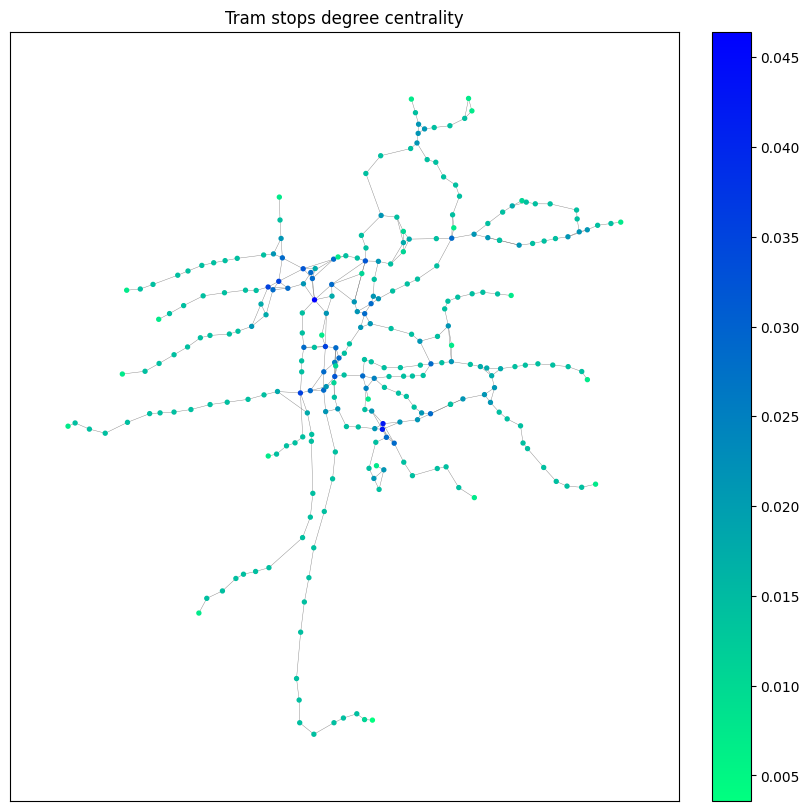

In [117]:
fig, ax = plt.subplots(figsize=(8, 8), layout='constrained')
ax.set_title('Tram stops degree centrality')

# calculate degree centrality
dcent = nx.degree_centrality(G)

# draw edges
nx.draw_networkx_edges(G.to_undirected(), **{
    'pos' : GPS,
    'edge_color' : 'gray',
    'width' : 0.3
})

# draw nodes
cbar = nx.draw_networkx_nodes(G, **{
    'pos' : GPS,
    'node_color' : list(dcent.values()),
    'node_size' : 8,
    'cmap' : plt.cm.winter_r,
})

fig.colorbar(cbar)
fig.show()

Z vizualizace můžeme pozorovat, že větší stupňovou centralitu mívají zastávky v centru. Naopak infrastruktura zastávek se zmenšuje se vzdáleností od centra.

Z toho můžeme jednoduše vyvodit, že centrum Prahy má hustější infrastrukturu zastávek.

### Centralita blízkosti
Opět v rámci tramvajové sítě nám bude tato centralita říkat, z kterých zastávek se nejlépe dostaneme ke všem ostatním v Praze.

/tmp/ipykernel_14347/3199949282.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


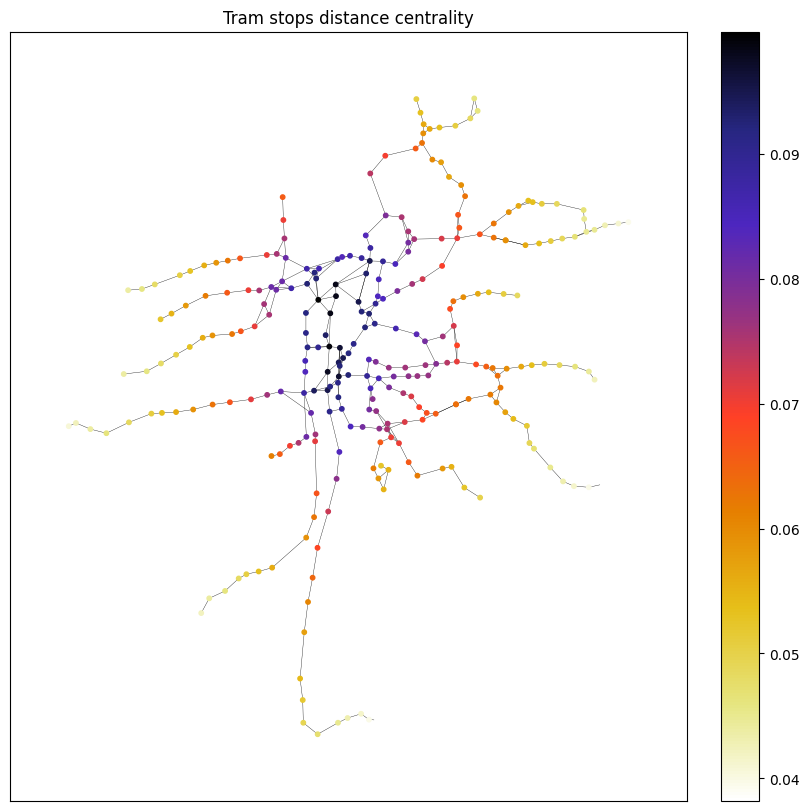

In [118]:
# convert to undirected
G_nd = G.to_undirected()

# check for connectivity
if nx.is_connected(G_nd):
    ccent = nx.closeness_centrality(G_nd)

    # plot graph
    fig, ax = plt.subplots(figsize=(8, 8), layout='constrained')
    ax.set_title('Tram stops distance centrality')

    # draw nodes
    mcl = nx.draw_networkx_nodes(G_nd, **{
        'pos' : GPS,
        'node_color' : list(ccent.values()),
        'cmap': plt.cm.CMRmap_r,
        'node_size' : 10,
    })
    
    # draw edges
    nx.draw_networkx_edges(G_nd, pos=GPS, width=0.25)

    fig.colorbar(mcl)
    fig.show()
    
else:
    print('Graph is not connected')

Z grafu je vidět, že do všech částí Prahy se dostaneme nejlépe z centra.

To jednoduše platí, protože střed je nejblíže ke všem okrajům.

### Centralita mezilehlosti
Tato centralita nám říká, jak často se daná zastávka objevuje v nejkratších cestách mezi ostatními zastávkami.

Vypočítám tedy pro každou zastávku centralitu mezilehlosti. A zobrazím si 5 nejrelevantnějších zastávek.

Max betweenness centrality: 0.3411205249670113



/tmp/ipykernel_14347/2499203711.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


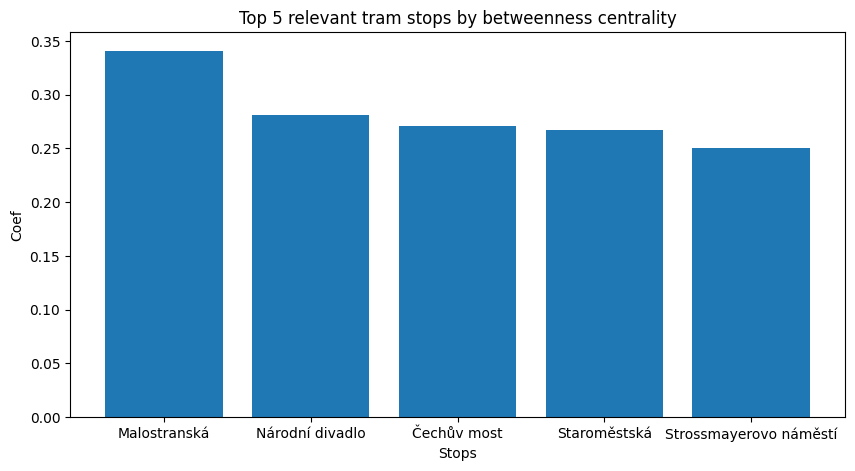

In [119]:
# calculate centrality
bcent = nx.betweenness_centrality(G)
print('Max betweenness centrality:', max(bcent.values()), end='\n\n')

# get top 5 stops and convert it into dict
bcent_stops = dict(sorted([(key, value) for key, value in bcent.items()], key=lambda x: x[1], reverse=True)[0:5])

# plot bar chart with top 5 stops
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Top 5 relevant tram stops by betweenness centrality')
ax.set_xlabel('Stops')
ax.set_ylabel('Coef')

ax.bar(list(bcent_stops.keys()), list(bcent_stops.values()))

fig.show()

Mezi 5 nejrelevantějších zastávek v rámci mezilehlosti se řadí:
- Malostranská
- Národní divadlo
- Čechův most
- Staroměstská
- Strossmayerovo náměstí

Tyto zastávky by se daly považovat jako nejfrekventovanější v rámci tramvajových spojů.

Zobrazím tedy ještě samotnou síť zastávek s barvou vrcholů podle centrality.

Navíc ještě ozačním zmíněné zastávky.

/tmp/ipykernel_14347/2129736651.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


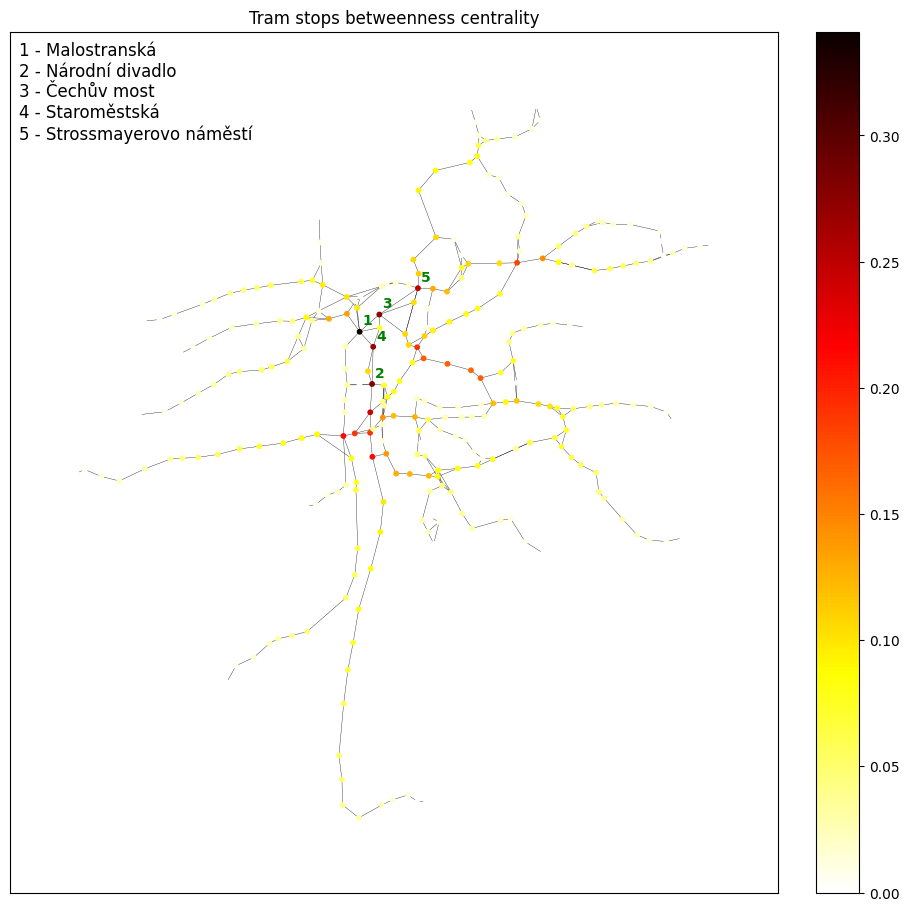

In [120]:
fig, ax = plt.subplots(figsize=(9, 9), layout='constrained')
ax.set_title('Tram stops betweenness centrality')

# fill labels coding to numerical values
labels_coding = {}
for idx, stop in zip(range(1,6), bcent_stops):
    labels_coding[stop] = idx

nx.draw_networkx_edges(G_nd, pos=GPS, width=0.25)
nx.draw_networkx_labels(G_nd, **{
    'pos' : offset_labels_pos(GPS, 0.003, 0.002),
    'labels' : labels_coding,
    'font_size' : 10,
    'font_weight' : 'bold',
    'font_color' : 'green'
})

mcl = nx.draw_networkx_nodes(G_nd, **{
    'pos' : GPS,
    'node_color' : list(bcent.values()),
    'cmap': plt.cm.hot_r,
    'node_size' : 10,
})

legend_text = ""
for stop, idx in labels_coding.items():
    legend_text += str(idx) + ' - ' + stop + '\n'
    
fig.text(0.015, 0.96, legend_text, fontsize=12, verticalalignment='top')

fig.colorbar(mcl)
fig.show()

Vidíme, že se jedná o zastávky, které nějakým způsobem spojují okrajové části Prahy s centrem.

To znamená, že pokud se budeme chít z okraje Prahy dostat do centra, tak dost pravděpodobně pojedeme přes tyto zastávky.

### Centralita váženého průměru hran
Tato centralita nám zobrazí zastávky, které jsou připojeny na důležitější uzly v síťi. Neboli jak vliv každé zastávky roste s vlivem sousedních zastávek.

Vykreslím tedy opět graf obarvený podle centrality.

Želivského: 3.82844698466422e-06


/tmp/ipykernel_14347/1525241107.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


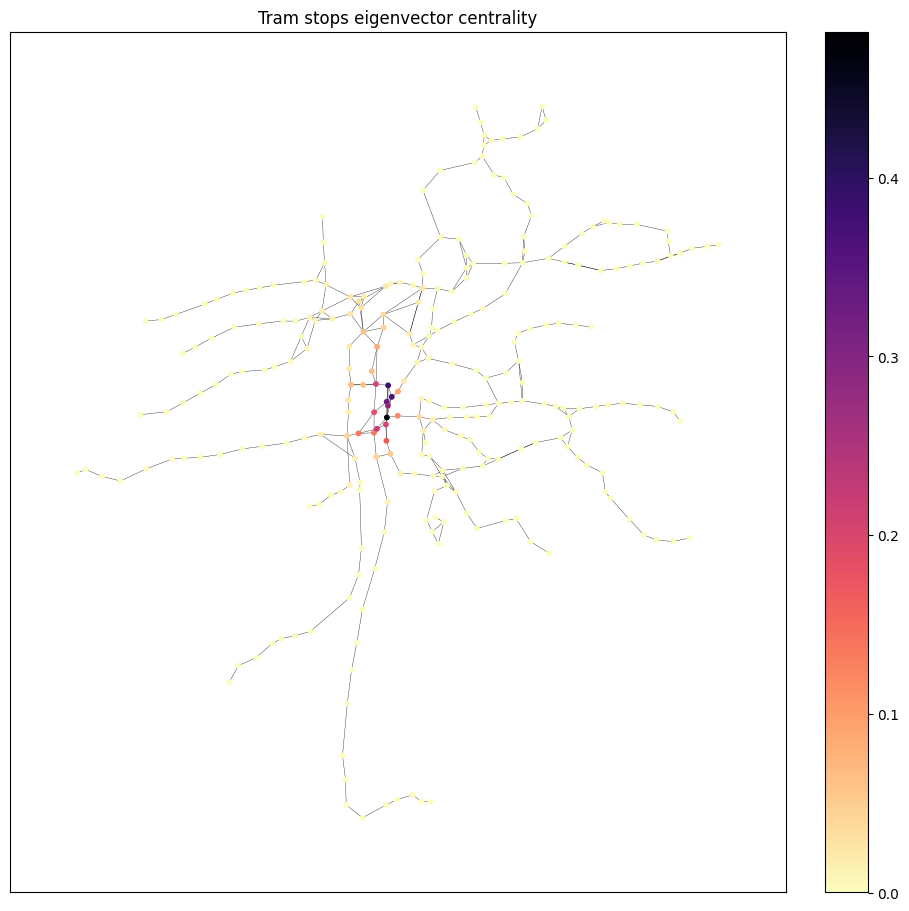

In [121]:
eigenvector = nx.eigenvector_centrality(G.to_undirected(), max_iter=500)

print(*max(eigenvector.items()), sep=': ')

fig, ax = plt.subplots(figsize=(9, 9), layout='constrained')
ax.set_title('Tram stops eigenvector centrality')

mcl = nx.draw_networkx_nodes(G_nd, **{
    'pos' : GPS,
    'node_color' : list(eigenvector.values()),
    'cmap': plt.cm.magma_r,
    'node_size' : 10,
})
nx.draw_networkx_edges(G_nd, pos=GPS, width=0.25)

fig.colorbar(mcl)
fig.show()

Můžeme vidět, že zastávky sousedící s nejlvivnějšími zastávkami jsou lokalizovány v centru Prahy.

Tato centralita nám tedy svým způsobem popsala hustotu a důležitost infrastuktury zastávek.

Dle této centrality je nejduleřitější zastávka: `Želivského`.

## Vlastní otázky
V této sekci se pokusím zodpovědět vlastní otázky.

### Jak se dostat z bodu A do bodu B?
Tato otázka je běžným příkladem z reálného života, kdy se člověk potřebuje někam dostat.

Pro jednoduchost budu tedy uvažovat pouze tramvajové spoje a bude mě zajímat jak se dostat ze zastávky **Dejvická** do zastávky **Vysočasnká**.

Tuto skutečnost vizualizuji na předchozím grafu se zvýrazněnou cestrou. Dále vypíšu dobu jízdy (čas strávený v tramvaji) a posloupnpost zastávek na nejkratší trase. Zároveň se budu snažit o univerzálnost kódu tak, aby stačilo pouze změnit body a graf se sám překreslil.

Pro výpočet doby jízdy si vytvořím funkci, která mi bude pro libovolnou cestu vracet čas jízdy.

In [122]:
# select tram data and filter necessary columns
tram = data[data['route_type'] == 0]
tram_time_df = tram.drop(['stop_from', 'stop_to', 'weekly'], axis=1).drop(tram.loc[:, 'depart_from':'sunday'], axis=1).drop_duplicates()

def calc_path_time(path: list) -> pd.Timedelta:
    """ Calculates delta time for given path """

    time_sum = pd.Timedelta(0)

    # loop trough path stops and sum up delta time
    for i in range(1, len(path) - 1):
        time_sum += tram_time_df[(
            tram_time_df['stop_from_name'] == path[i - 1]) & (tram_time_df['stop_to_name'] == path[i]
        )].iloc[0]['delta_time']

    return time_sum

Následně tedy vykreslím na graf tramvajové sítě cestu s očekávanou dobou jízdy a seznamem mezizastávek.

/tmp/ipykernel_14347/3505632236.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


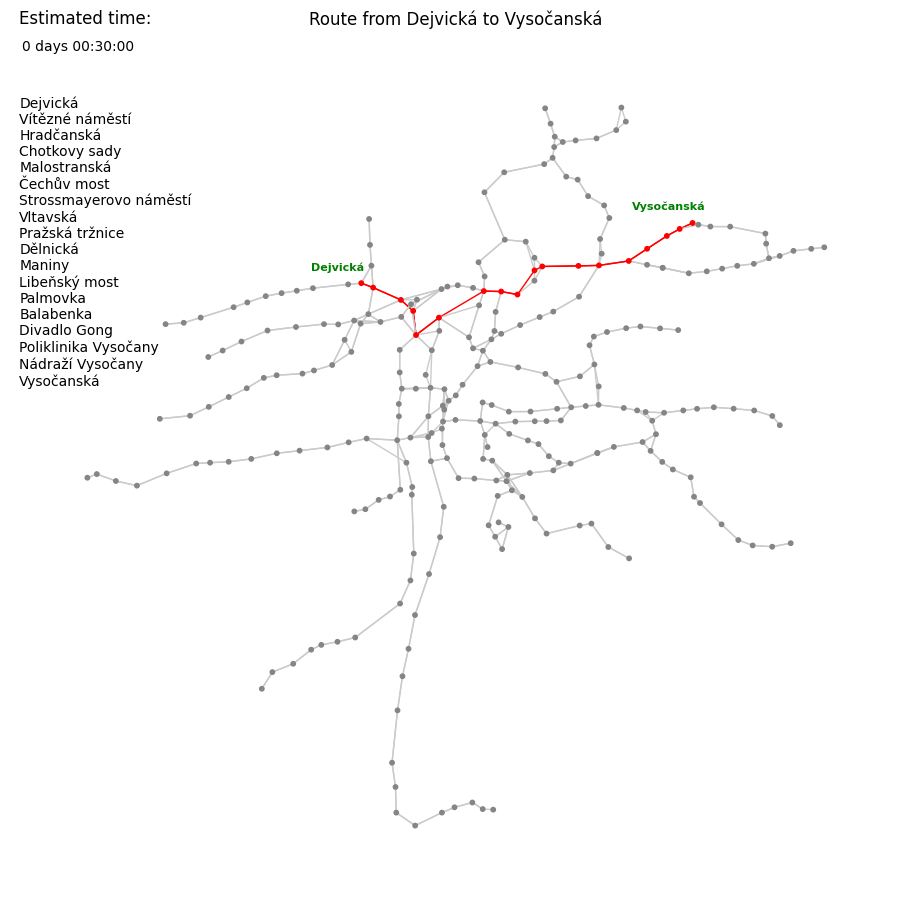

In [123]:

# find shortest path
start, end = 'Dejvická', 'Vysočanská'
path = nx.shortest_path(G, start, end)

# fill colormap for path
node_colormap = ['r' if node in path else '#858585' for node in G.nodes]
edge_colormap = ['r' if (edge[0] in path) and (edge[1] in path) else '#cacbcc' for edge in G.edges]

# plot graph
fig, ax = plt.subplots(figsize=(9, 9), layout='constrained')
ax.set_title(f"Route from {start} to {end}")

# draw edges and nodes
nx.draw(G.to_undirected(), **{
    'pos' : GPS,
    'edgelist' : G.edges,
    'node_color' : node_colormap,
    'edge_color' : edge_colormap,
    'node_size' : 10,
})

# draw start and end path labels
nx.draw_networkx_labels(G, **{
    'pos' : offset_labels_pos(GPS, -0.008, 0.003),
    'labels' : { start : start, end : end },
    'font_size' : 8,
    'font_color' : 'green',
    'font_weight' : 'bold'
})

# add estimated time text
fig.text(0.015, 0.98, 'Estimated time:', fontsize=12)
fig.text(0.018, 0.95, str(calc_path_time(path)), fontsize=10)

# ad path stops text
path_text = ""
for stop in path:
    path_text += stop + '\n'

fig.text(0.015, 0.9, path_text, fontsize=10, verticalalignment='top')

fig.show()

Kdyby se ted yběžný človek potřeboval dostat ze zastávky **Dejvická** do zastávky **Vysočanská**, tak mi tato vizualizace přijde jako dostatečná.

### Jak se liší frekvence dopravy tramvají v nočích a denních hodinách?
Na tuto otázku by se dalo odpovědět vizualizací grafu, který byl již zobrazen výše. A to pro právě týdenní zátěž spojů.

Provedu tedy filtraci dat pdole nočních a denních jízd a tyto dva grafy zobrazím vedle sebe.

Ideálně budu chtít dosáhnout vykreslení se stejným měřítkem pro váhy obou grafů.

In [124]:
# create two graps for day and night routes
Gnight = create_stops_graph(data[(data['route_type'] == 0) & (data['is_night'] == 1)]).to_undirected()
Gday = create_stops_graph(data[(data['route_type'] == 0) & (data['is_night'] == 0)]).to_undirected()

/tmp/ipykernel_14347/812211441.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


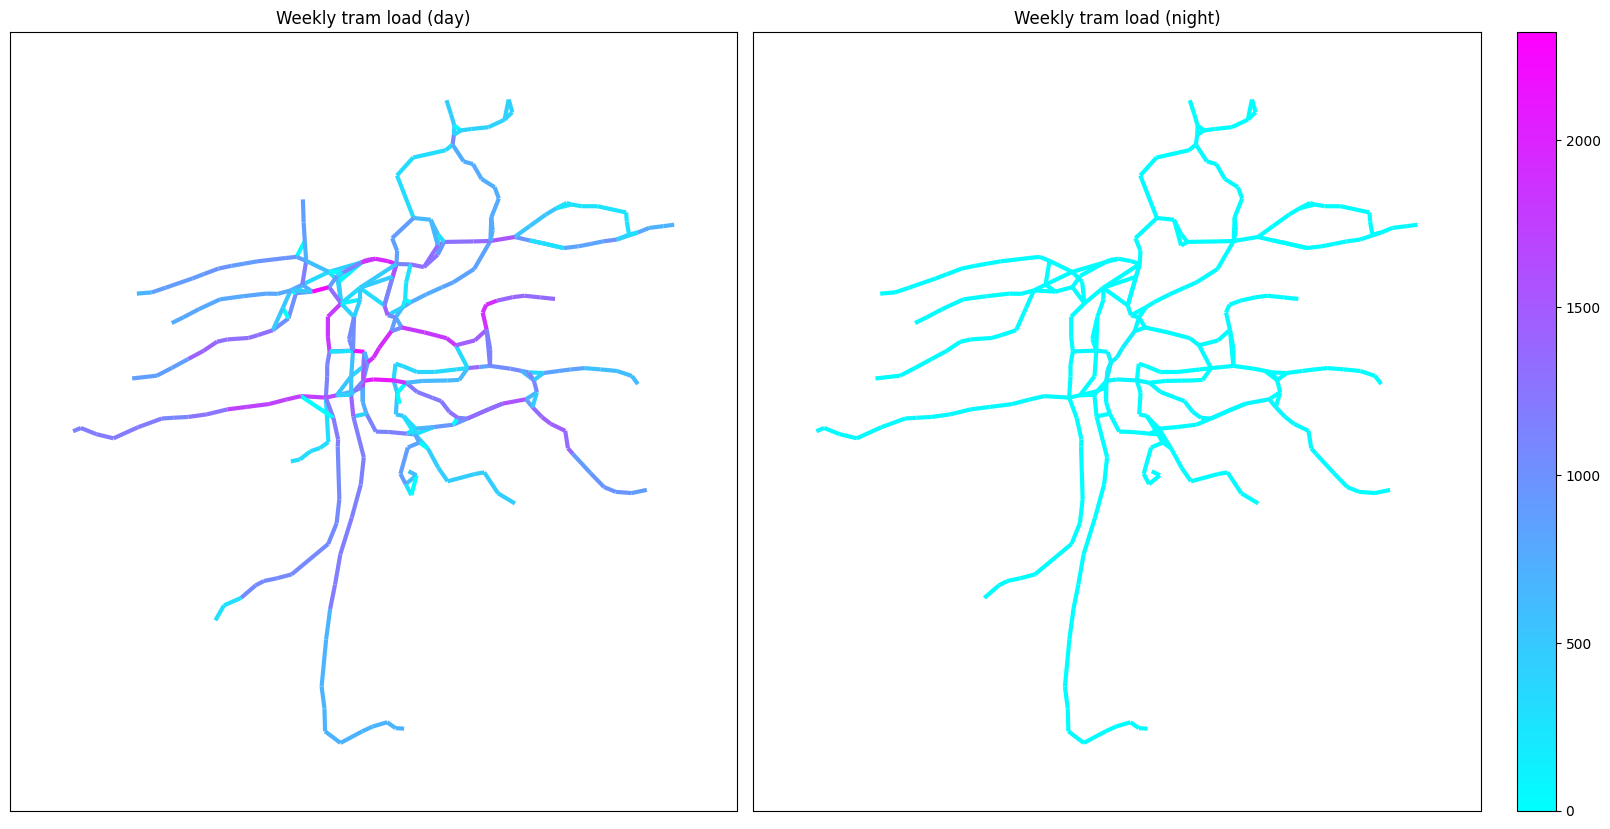

In [125]:
# get day and night edge weights
w_day, w_night = nx.get_edge_attributes(Gday, 'weight'), nx.get_edge_attributes(Gnight, 'weight')
vmin, vmax = 0, np.max(list(w_day.values()))

graph_opt = {
    'pos' : GPS,
    'edge_cmap': plt.cm.cool,
    'width': 3,
    'node_size' : 5,
}

fig, ax = plt.subplots(figsize=(16, 16), layout='constrained')
ax.remove()

# day subplot
ax = plt.subplot(221)
plt.title('Weekly tram load (day)')
nx.draw_networkx_edges(Gday, **graph_opt, **{
    'edgelist' : list(w_day.keys()),
    'edge_color' : list(w_day.values()),
    'edge_vmin' : vmin,
    'edge_vmax' : vmax
})

# night subplot
plt.subplot(222)
plt.title('Weekly tram load (night)')
mcl = nx.draw_networkx_edges(Gnight, **graph_opt, **{
    'edgelist' : list(w_night.keys()),
    'edge_color' : list(w_night.values()),
    'edge_vmin' : vmin,
    'edge_vmax' : vmax
})

fig.colorbar(mcl)
fig.show()

Z grafu je očividné, že přes den je tramvajová síť více zatížená a tuto metriku nelze moc srovnávat z důvodu velkého rozdílu zatížení. Každopádně tato vizualizace vhodně odpovídá na položenou otázku.

*Komentář k techinckému řešení: Zvolená barevná paleta není kvůli velkému hodnotovému rozídlu grafů ideální. Oproti dalším monochromatickým paletám mi ale přišlo nejvhodnější vybrat sekvenční paletu bez bílé barvy.*

### Které autobusové zastávky podporují bezbariérový přístup?
Pro zodpovězení této otázky bych chtěl vykreslit všechny autobusové zastávky bez hran a barevně je odlišit podle toho, jaký typ bezbariérového přístupu podporují.

Dle dokumentace jsou u zastávek, které nemají nadřazenou zastávku 3 typy hodnot:
- Nemáme informaci o bezb. přístupu
- Bezbariérový přístup je možný v některých vozidlech projíždějící touto zastávkou
- Bezbariérový přístup není možný

Pro jednoduchost budu vykreslovat pouze zastávky s unikátním názvem a bez nadřazené zastávky. V případě stejných názvů zastávek a jinou lokací, zprůměruji jejich GPS souřadnice. Bezbariérový přístup při nerozhodnosti budu brát jako kdybych o zastávce němel žádnou informaci.

Nejdříve tedy provedu filtraci autobusových zastávek pdole unikátních jmen a bez nadřazené zastávky.

In [126]:
# select bus stop names and parse to unique
bus_stops = data[data['route_type'] == 3][['stop_from_name', 'stop_to_name']]
unique_bus_stops = set(pd.Series(list(bus_stops['stop_from_name']) + list(bus_stops['stop_to_name'])))

imp_columns = ['stop_name', 'stop_lat', 'stop_lon', 'wheelchair_boarding']

# filter by not having parent station and check if in unique names
filtered_stops = stops[(
    stops['parent_station'].isna()) & (stops['stop_name'].isin(unique_bus_stops)
    )][imp_columns].sort_values('stop_name', axis=0).rename({
        'wheelchair_boarding' : 'wheelchair'
    }, axis=1)

display(filtered_stops.head())

,stop_name,stop_lat,stop_lon,wheelchair
3843,Ametystová,49.988201,14.362216,0
3300,Amforová,50.041851,14.327283,0
3301,Amforová,50.041851,14.327283,0
3302,Amforová,50.041706,14.327312,0
3303,Amforová,50.041706,14.327312,0


Následně dat aagreguji podle jmen zastávek pomocí průměru.

Takto bude lokace zastávky přibližně uprostřed zastávek se stejným jménem. Informace o bezbariérovém přístupu bude nabývat hodnot `[0, 1, 2, jiné]`. Kde `jiné` bude nějaké desetinné číslo.


In [127]:
# group by name and average GPS, then round 
filtered_stops = filtered_stops.groupby('stop_name').mean().reset_index()
display(filtered_stops.head())

,stop_name,stop_lat,stop_lon,wheelchair
0,Ametystová,49.988201,14.362216,0.000
1,Amforová,50.041778,14.327298,0.000
2,Anděl,50.071421,14.403314,0.625
3,Antala Staška,50.041607,14.444361,0.000
4,Apolinářská,50.071510,14.426755,0.000


Vyfiltruji zastávky tak, že nerozhodné hodnoty budu brát jako neznámou informaci o bezb. přístupu.

In [128]:
def stop_filter(x):
    """ Filter by accessibility """

    return int(x) if x in [0, 1, 2] else 0

filtered_stops['wheelchair'] = filtered_stops['wheelchair'].apply(lambda x: stop_filter(x))

Menší podotázkou by mohlo být, jaký je tedy poměr zastávek, u kterých víme a nevíme informaci o přístupu.

Vykreslím tedy sloupcový graf pro tyto již zmíněné kategorie.

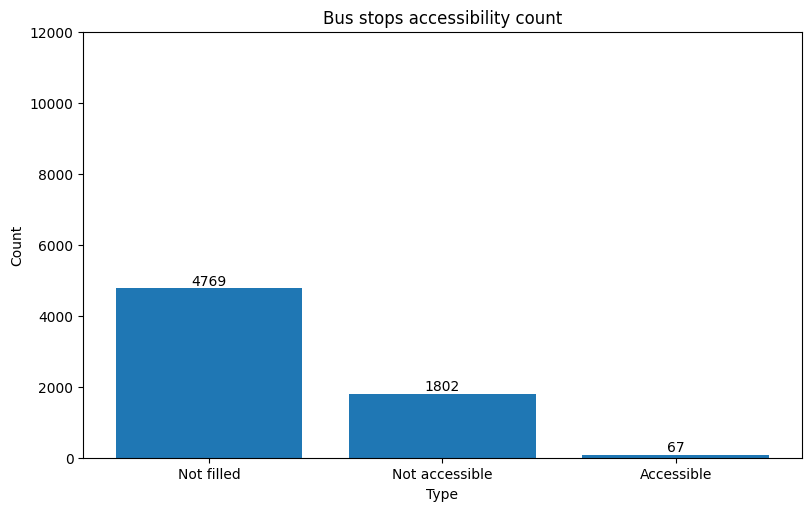

In [129]:
# count each category
counted_stops = (filtered_stops['wheelchair']
    .value_counts()
    .reset_index()
)

# code index number onto actual name of category
x, y = counted_stops['wheelchair'].apply(lambda x: {
    0 : 'Not filled',
    1 : 'Accessible',
    2 : 'Not accessible'
}[x]), counted_stops['count']

# plot bar chart
fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')
ax.set_title('Bus stops accessibility count')
ax.set_ylabel('Count')
ax.set_xlabel('Type')


# add count for each bar
ax.set_ylim(0, 12000)
y_offset = 100
for i in range(len(x)):
    plt.text(i, y[i] + y_offset, y[i], ha = 'center')


ax.bar(x, y)
plt.show()

Vidíme, že o masívní většině zastávek nemáme žádnou informaci. Z podporovaných zastávek jich je pouze `398`.

Dále tedy vytvořím z filtrovaných dat graf a každou zastávku obarvím podle jejího typu.

In [130]:
busG = nx.Graph()
bus_GPS, bus_color, bus_alpha = {}, [], []

# create colored node for each stop in filtered dataframe
for i, row in filtered_stops.iterrows():

    # add node with its GPS location
    busG.add_node(row['stop_name'])
    bus_GPS[row['stop_name']] = (row['stop_lon'], row['stop_lat'])

    # assign color and alpha to node
    if row['wheelchair'] == 0:
        bus_color.append('gray')
        bus_alpha.append(0.3)
    elif row['wheelchair'] == 1:
        bus_color.append('green')
        bus_alpha.append(1)
    else:
        bus_color.append('red')
        bus_alpha.append(0.8)

# split nodes into 3 lists
green_nodes = [n for n, color in zip(busG.nodes, bus_color) if color == 'green']
red_nodes = [n for n, color in zip(busG.nodes, bus_color) if color == 'red']
gray_nodes = [n for n, color in zip(busG.nodes, bus_color) if color == 'gray']

Teď už jen zbývá pro každou zastávku vykreslit bod.

Navíc ještě pro lepší orientaci v grafu **velmi přibližně** zvýrazním hranice Prahy a Středočeského kraje.

/tmp/ipykernel_14347/717621459.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


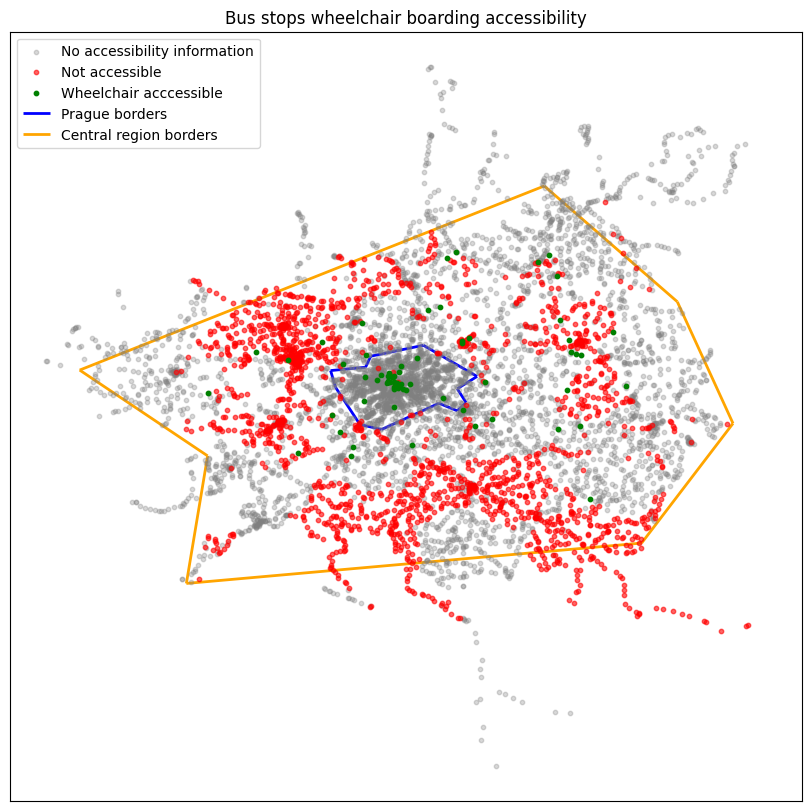

In [131]:
fig, ax = plt.subplots(figsize=(8, 8), layout='constrained')
ax.set_title('Bus stops wheelchair boarding accessibility')

# category settings
colors, alphas = ['gray', 'red', 'green'], [0.3, 0.6, 1]
labels = [
    'No accessibility information', 
    'Not accessible', 
    'Wheelchair acccessible'
]

# draw stops for each category
for i, category in enumerate([gray_nodes, red_nodes, green_nodes]):
    nx.draw_networkx_nodes(busG, **{
        'pos' : bus_GPS,
        'nodelist' : category,
        'node_color' : colors[i],
        'alpha' : alphas[i],
        'node_size' : 10,
        'label' : labels[i]
    })

# prague borders
prg = nx.Graph()
prg.add_edges_from([(x - 1, x) for x in np.arange(1, 12)] + [(11, 0)]) # build C11
prg_borders = {
    0 : (14.705477, 50.090426),
    1 : (14.531883, 50.176975),
    2 : (14.361939, 50.146623),
    3 : (14.345116, 50.115922),
    4 : (14.232163, 50.106675),
    5 : (14.248299, 50.059971),
    6 : (14.326920, 49.956930),
    7 : (14.396958, 49.943012),
    8 : (14.582352, 50.015869),
    9 : (14.641403, 49.994907),
    10 : (14.669899, 50.017855),
    11 : (14.641403, 50.056224)
}

nx.draw_networkx_edges(prg, **{
    'pos' : prg_borders,
    'edge_color' : 'blue',
    'width' : 2,
    'label' : 'Prague borders'
})

# central region borders
central_reg = nx.Graph()
central_reg.add_edges_from([(x - 1, x) for x in np.arange(21, 27)] + [(26, 20)]) # build C7
central_reg_borders = {
    20 : (15.532275, 49.959852),
    21 : (15.352374, 50.297911),
    22 : (14.922534, 50.619645),
    23 : (13.421527, 50.108046),
    24 : (13.834888, 49.869654),
    25 : (13.766223, 49.515196),
    26 : (15.237018, 49.627410)
}

nx.draw_networkx_edges(central_reg, **{
    'pos' : central_reg_borders,
    'edge_color' : 'orange',
    'width' : 2,
    'label' : 'Central region borders'
})

ax.legend()
fig.show()

Hlavním poznatkem bude, že nejvíce zastávek podporujících bezb. přístup se nachází v Praze. mimo Prahu se taktéž nachází malé množství.
Pravděpodobně půjde o nějaká další města.